<a href="https://colab.research.google.com/github/stefanogiagu/corsoinfn/blob/main/notebooks/Hands_on_1_CNN_su_Acceleratori_FPGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training e compressione di una CNN a media latenza per il trigger di alto livello di vertici secondari nello spettrometro muonico dell'esperimento ATLAS

*   training di un modello CNN VGG-like
*   compressione tramite pruning con pruning
*   compressione tramite quantizzazione a 8bit con tensorflow
*   compressione tramite quantizzazione a 8bit con VitisAI
*   compilazione del modello quantizzato su acceleratore Alveo U50 con VitisAI

Referenze: <p>
[Tensorflow Model Optimization](https://www.tensorflow.org/model_optimization/guide) <p>
[VitisAI](https://www.xilinx.com/products/design-tools/vitis/vitis-ai.html) <p>

Dataset disponibile su google drive e accessibile da google colab:

https://drive.google.com/file/d/1-9zsMPx7a4fYIeYJk4SEqj0Ot7jyzejH/view?usp=sharing

aprire il file dal browser, aggiungere uno short cut al proprio google drive, e poi montare il google drive da google colab



```
from google.colab import drive
drive.mount('/content/drive')
```


Se si vuole copiare il file sulla propria macchina locale (sono 3.5GB):



```
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-9zsMPx7a4fYIeYJk4SEqj0Ot7jyzejH' -O- | sed -rn 's/.*confirm=([1-9A-Za-z_]+).*/\1\n/p')&id=1-9zsMPx7a4fYIeYJk4SEqj0Ot7jyzejH" -O MS_vertex_decays_10_v2.npz && rm -rf /tmp/cookies.txt
```



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tempfile
import os
import numpy as np
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
# Lettura del dataset, in formato numpy compresso (.npz)

# 10000 immagini (eventi) 20x333 (layers MDT ATLAS, coordinata z) degli hit nello spettrometro muonico rilasciati dal decadimento di nuove particelle che decadono in multi muoni
# 'data_noise': array immagini (1000,20,333)
# 'labels': array (10000,3) in cui la prima grandezza rappresenta la distanza di decadimento della particelle che ha prodotto l'immagine

input_file = np.load('drive/MyDrive/MS_vertex_decays_10_v2.npz')
labels = input_file['labels']
data_noise = input_file['data_noise']

print("data_noise shape : ",data_noise.shape)
print("labels shape :     ",labels.shape)

data_noise shape :  (10000, 20, 333)
labels shape :      (10000, 3)


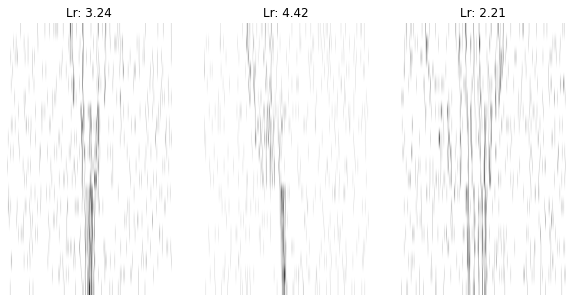

In [ ]:
# esempio di immagini
plt.figure(figsize=(10,5))
for i, idx in enumerate([0,10,30]):
  plt.subplot(1,3,i+1)
  plt.imshow(data_noise[idx], origin='lower', aspect='auto', cmap='binary')
  plt.axis('off')
  plt.xlabel('z')
  plt.ylabel('mdt layer')
  plt.title('Lr: '+str(round(labels[idx,0],2)))

In [ ]:
# Preprocessamento dei dati:

# utilizziamo solo la prima variabile delle label (distanza di decadimento) per addestrare la CNN a predire tale variabile
decay_lenght = labels[:,0]

# dividiamo il dataset in training and test set utilizzando il metodo train_test_split di sklearn
from sklearn.model_selection import train_test_split
train_to_test_ratio = 0.8 # training set 80%, test set 20% 

X_train,X_test,Y_train,Y_test = train_test_split(data_noise, decay_lenght, train_size=train_to_test_ratio, shuffle=True, random_state=1234)

# reshaping delle immagini da (10000,20,333) a (10000,20,333,1) come richiesto da layer convoluzionali in keras
X_train = X_train.reshape((X_train.shape[0], 20, 333,1))
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

# conversione dei valori degli array a float32 come richiesto da keras
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')
X_test = X_test.astype('float32')
Y_test  = Y_test.astype('float32') 

# NOTA: in questo esempio specifico non è necessario normalizzare i vettori delle immagini ad avere valori in [0,1] o con media=0 e sdev=1, perché le immagini
# sono di tipo binario (i pixel hanno solo valori 0 o 1)


(8000, 20, 333, 1)
(8000,)
(2000, 20, 333)
(2000,)


In [ ]:
# Modello Convoluzionale

# Usiamo un'archiettura CNN tipo VGG, semplice da implementare e che funziona bene per identificare i tipici pattern di particelle in rivelatori 
# traccianti

# modello funzionale
inputs = keras.Input(shape=(20,333,1))

# primo blocco convoluzionale (tre convoluzioni 2D con 32 kernel 3x3 (che corrispondono ad un campo ricettivo 7x7) + attivazione relu per inserire 
# non linerità nel modello e un max pooling finale 

# NOTA: usiamo padding='same' nelle convoluzioni e utilizziamo un layer di max pooling per il downsampling dell'output 
x = keras.layers.Conv2D(32, kernel_size=(3,3), padding='same')(inputs)
x = keras.layers.Conv2D(32, kernel_size=(3,3), padding='same')(x)
x = keras.layers.Conv2D(32, kernel_size=(3,3), padding='same')(x)
x = keras.layers.ReLU(name='ReLU')(x)
x = keras.layers.MaxPool2D((2,3))(x)

# secondo blocco convoluzionale: una convoluzione 2D con 64 kernel (3,3) + relu + max pooling
x = keras.layers.Conv2D(64, kernel_size=(3,3), padding='same')(x)
x = keras.layers.ReLU(name='ReLU1')(x)
x = keras.layers.MaxPool2D((2,3))(x)

# terzo blocco convoluzionale: una convoluzione 2D con 128 kernel (3,3) senza padding + relu + max pooling (solo lungo la seconda dimensione)
x = keras.layers.Conv2D(128, kernel_size=(3,3))(x)
x = keras.layers.ReLU(name='ReLU2')(x)
x = keras.layers.MaxPool2D((1,3))(x)

# quarto blocco convoluzionale: una convoluzione 2D con 256 kernel (3,3) senza padding + relu + max pooling (solo lungo la seconda dimensione)
x = keras.layers.Conv2D(256, kernel_size=(3,3))(x)
x = keras.layers.ReLU(name='ReLU3')(x)
x = keras.layers.MaxPool2D((1,3))(x)

# flatten layer per adattare l'uscita dell'ultima convoluzione al blocco fully connected usato per la task di regressione
x = keras.layers.Flatten()(x)

# fully connected block: layer densi + relu + dropout come regolarizzatore per ritardare l'overfitting
x = keras.layers.Dense(512)(x)
x = keras.layers.ReLU(name='ReLU4')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(512)(x)
x = keras.layers.ReLU(name='ReLU5')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(1)(x)
outputs = keras.layers.ReLU(name='ReLU6')(x)

# modello finale
model = keras.Model(inputs=inputs, outputs=outputs)

# printout della struttura del modello
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 333, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 333, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 333, 32)       9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 333, 32)       9248      
                                                                 
 ReLU (ReLU)                 (None, 20, 333, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 111, 32)      0         
 )                                                               
                                                             

In [ ]:
# Compilazione del modello

# Ottmizzatore: usiamo Adam con larning rate iniziale fisso
LR_ST=1e-3
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss: usiamo huber_loss (va bene anche mse, ma huber_loss tende a funzionare meglio con dati molto sparsi come quelli delle "immagini" di 
# rivelatori di particelle)

# https://www.tensorflow.org/api_docs/python/tf/keras/losses/Huber
# hloss = 0.5 * x**2                  if |x| <= d
# hloss = 0.5 * d**2 + d * (|x| - d)  if |x| > d

# sostanzialmente si comporta come mse intorno a zero e come mae per gli outliers 

model.compile(optimizer=OPTIMIZER,
              loss='huber_loss',
              metrics=['mae'])

In [ ]:
# schedule:

# usiamo una semplice learnign rate schedule per variare (diminuire) durante il training il larning-rate
# in modo che valori iniziali più grandi permettano una buona esplorazione del landscape della loss, e valori più 
# piccoli permettano una esplorazione dettagliata una volta individuata una regione di minimo  

# prime 5 epoche LR costante, poi decay esponenziale
def lr_decay(epoch):
  if epoch < 5:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (5 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)


# schedula per salvare il modello migliore durante il training. Viene monitorata la mae sul campione di 
# validazione ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best',
        monitor='val_mae',
        save_weights_only=False, 
        save_best_only=True,
        save_freq='epoch')


In [ ]:
# Addestramento del modello

epoche = 30
batch_size = 64

# usiamo 20% del trainign set come campione di validazione per decidere quando fermarsi tramite la schedula del model_checkpoint
history = model.fit(X_train, Y_train, epochs=epoche, batch_size=batch_size,
                    validation_split=0.2, shuffle=True, verbose=1, callbacks=[lr_scheduler, model_checkpoint])

Epoch 1/30
100/100 [==============================] - 24s 125ms/step - loss: 0.3694 - mae: 0.7218 - val_loss: 0.1564 - val_mae: 0.4636 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 12s 118ms/step - loss: 0.1654 - mae: 0.4685 - val_loss: 0.1045 - val_mae: 0.3618 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 9s 89ms/step - loss: 0.1257 - mae: 0.4017 - val_loss: 0.1091 - val_mae: 0.3823 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 10s 103ms/step - loss: 0.1128 - mae: 0.3799 - val_loss: 0.1022 - val_mae: 0.3480 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 9s 88ms/step - loss: 0.0901 - mae: 0.3369 - val_loss: 0.1158 - val_mae: 0.4003 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 13s 126ms/step - loss: 0.0752 - mae: 0.3078 - val_loss: 0.0680 - val_mae: 0.2894 - lr: 0.0010
Epoch 7/30
100/100 [==============================] - 13s 129ms/step - loss: 0.0617 - mae: 0.2777 - val_loss: 0.0703

In [ ]:
# salviamo il modello migliore ottenuto
model.load_weights('best')
model.save('float_model_best_10.h5')

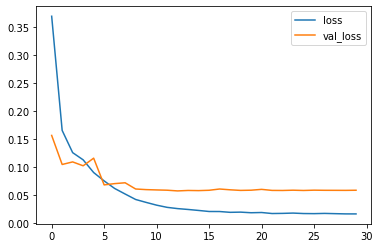

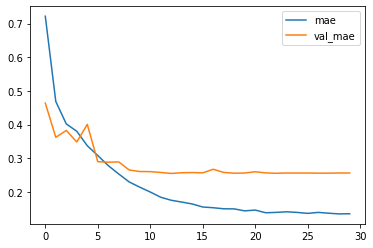

In [ ]:
# plot loss e mae vs epoca di training

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label = 'mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.legend()
plt.show()

In [ ]:
# lettura del modello addestrato
from tensorflow import keras 
model = keras.models.load_model('float_model_best_10.h5')

In [ ]:
# prestazioni sul test set
score = model.evaluate(X_test, Y_test, verbose=2)

63/63 - 2s - loss: 0.0598 - mae: 0.2585 - 2s/epoch - 25ms/step


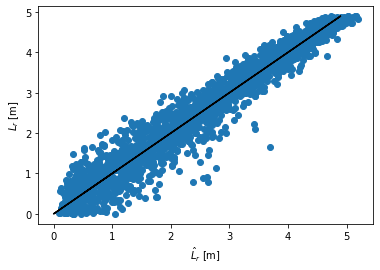

In [ ]:
# scatter plot distanza di decadimento vera vs distanza di decadimento predetta

Y_predetta = model.predict(X_test.reshape((X_test.shape[0],20,333,1)))
plt.scatter(Y_predetta,Y_test)
plt.xlabel("$\hat{L}_r$ [m]")
plt.ylabel("$L_r$ [m]")
plt.plot(Y_test, Y_test ,'k-')

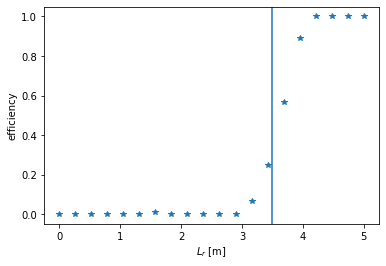

In [ ]:
# Turnon curva di efficienza del trigger in funzione della distanza di decadimento

# modo facile per ottenerlo: creare due histogrammi uno con la distribuzione di Lr per gli eventi che passono il taglio 
# Lr_predetto > soglia e uno con la distribuzione di tutti gli eventi e poi fare il rapporto tra i due istogrammi

soglia = 3.5 #soglia nominale di trigger 
numer,_ = np.histogram(Y_test[Y_predetta.reshape(Y_predetta.shape[0],)>soglia], bins=20, range=(0.,5.))
denum,_ = np.histogram(Y_test, bins=20, range=(0.,5.))

eff = numer/denum
lrvalues = np.linspace(0.,5.,20)

_ = plt.plot(lrvalues,eff, '*')
_ = plt.axvline(x=soglia)
_ = plt.xlabel("$L_r$ [m]")
_ = plt.ylabel("efficiency")

In [ ]:
# Installazione della libreria tensorflow model optimization
# fornisce diversi strumenti per l'ottimizzazione di modelli di NN per la riduzione della latenza, memory footprint, power consumption, network usage, 
# Moduli: weight pruning (per ridurre il numero di parametri della rete), quantization (a 8 bit,  per ridurre io memory foot print, e ottimizzare il trasferimento 
# dei dati verso/dalla memoria), weight clustering e ottmizzazione collaborativa (i parametri del modello vengono sostituiti da un umero più piccolo di valori unici) 

# 
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 237 kB 4.3 MB/s 


In [ ]:
#Pruning
import tensorflow_model_optimization as tfmot


# carichiamo il modello baseline non compresso 
baseline_model = keras.models.load_model('float_model_best_10.h5')


# Definiamo il modello di pruning da utilizzare: 
# si parte da una spasity iniziale per layer del 50% (50% dei pesi azzerati) per arrivare ad
# una sparsity dell'80% (80% dei pesi azzerati) 
# il passaggio avviene con una schedula di decadimento polinomiale

# numero di step di ottmizzazione:

# nel pruning **NON** è una buona strategia ri-addestrare la rete, ma conviene solo fare un po' di fine tuning 
# addestrando per poche epoche
epochs=5
batch_size=64

# numero di step
end_step = np.ceil(X_train.shape[0] / batch_size).astype(np.int32) * epochs

pruning_params = {
  'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}


# applichiamo il pruning solo ai layer densi (quelli che hanno la maggior parte dei parametri)
# prune_low_magnitude elimina i pesi più piccoli in valore assoluto (è un wrapper che prende in input un layer, o una sequenza di layer, o un intero modello)
def apply_pruning_to_dense(layer):
  if isinstance(layer, tf.keras.layers.Dense):
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer

# Usiamo `tf.keras.models.clone_model` per applicare `apply_pruning_to_dense`  ai layer del modello.
model_for_pruning = tf.keras.models.clone_model(
    baseline_model,
    clone_function=apply_pruning_to_dense,
)


# Compilazione (stessi parametri del modello baseline)
LR_ST=1e-3
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

model_for_pruning.compile(optimizer=OPTIMIZER,
              loss='huber_loss',
              metrics=['mae'])

model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 333, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 333, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 333, 32)       9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 333, 32)       9248      
                                                                 
 ReLU (ReLU)                 (None, 20, 333, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 111, 32)      0         
 )                                                               
                                                             

Fine tune with pruning for two epochs.

tfmot.sparsity.keras.UpdatePruningStep is required during training, and tfmot.sparsity.keras.PruningSummaries provides logs for tracking progress and debugging.

In [ ]:
# Pruning e fine tuning del modello

# è necessario inserire una schedula durante il trainign che chiami tfmot.sparsity.keras.UpdatePruningStep()
# (si occupa di effetturare tutte le operazioni di pruning)

# tfmot.sparsity.keras.PruningSummaries viene usaro per monitorare i progressi e per debugging 


callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir='test'),
  keras.callbacks.ModelCheckpoint(
        filepath = 'best_pruned',
        monitor='val_mae',
        save_weights_only=False, 
        save_best_only=True,
        save_freq='epoch')
]
  
history = model_for_pruning.fit(X_train, Y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=0.2,
                  callbacks=callbacks)

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.0716 - mae: 0.2826

INFO:tensorflow:Assets written to: best_pruned/assets


INFO:tensorflow:Assets written to: best_pruned/assets


100/100 [==============================] - 16s 132ms/step - loss: 0.0716 - mae: 0.2826 - val_loss: 0.8463 - val_mae: 1.2646
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.1022 - mae: 0.3390

INFO:tensorflow:Assets written to: best_pruned/assets


INFO:tensorflow:Assets written to: best_pruned/assets


100/100 [==============================] - 14s 143ms/step - loss: 0.1022 - mae: 0.3390 - val_loss: 0.1053 - val_mae: 0.3697
Epoch 3/5
100/100 [==============================] - 9s 88ms/step - loss: 0.0687 - mae: 0.2878 - val_loss: 0.2707 - val_mae: 0.6372
Epoch 4/5
100/100 [==============================] - ETA: 0s - loss: 0.0665 - mae: 0.2823

INFO:tensorflow:Assets written to: best_pruned/assets


INFO:tensorflow:Assets written to: best_pruned/assets


100/100 [==============================] - 14s 145ms/step - loss: 0.0665 - mae: 0.2823 - val_loss: 0.0625 - val_mae: 0.2694
Epoch 5/5
100/100 [==============================] - 9s 88ms/step - loss: 0.0504 - mae: 0.2449 - val_loss: 0.0713 - val_mae: 0.3022


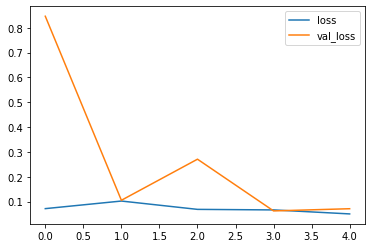

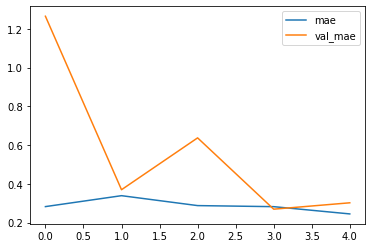

In [ ]:
# loss, mae vs epoca 
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label = 'mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.legend()
plt.show()

In [ ]:
# Per effetivamente comprimere il modello è necessario eliminare il keras wrapper usato durante il training 
# questo viene fatto usando il metodo tfmot.sparsity.keras.strip_pruning

# NOTA: per ridurre effettivamente il numero di pesi si deve comprimere il modello con tfLite (runtime essenziale di TF)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
tf.keras.models.save_model(model_for_export, 'pruned_model.h5', include_optimizer=False)
model_for_export.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 333, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 333, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 333, 32)       9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 333, 32)       9248      
                                                                 
 ReLU (ReLU)                 (None, 20, 333, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 111, 32)      0         
 )                                                               
                                                             

In [ ]:
# Prestazioni del modello pruned sul test set

pruned_model = keras.models.load_model('pruned_model.h5')
pruned_model.compile(optimizer=OPTIMIZER, loss='huber_loss',metrics=['mae'])

print('Baseline model:')
basescore = baseline_model.evaluate(X_test, Y_test, verbose=2)
print()
print('Pruned model:')
score = pruned_model.evaluate(X_test, Y_test, verbose=2)

Baseline model:
63/63 - 1s - loss: 0.0634 - mae: 0.2726 - 1s/epoch - 17ms/step

Pruned model:
63/63 - 1s - loss: 0.0634 - mae: 0.2726 - 1s/epoch - 21ms/step


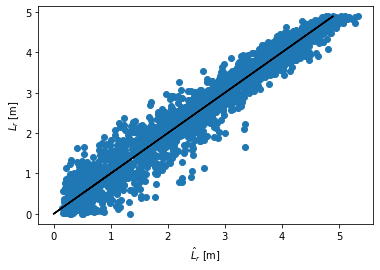

In [ ]:
predizioni_pruned = pruned_model.predict(X_test.reshape((X_test.shape[0],20,333,1)))
plt.scatter(predizioni_pruned,Y_test)
plt.xlabel("$\hat{L}_r$ [m]")
plt.ylabel("$L_r$ [m]")
plt.plot(Y_test, Y_test ,'k-')

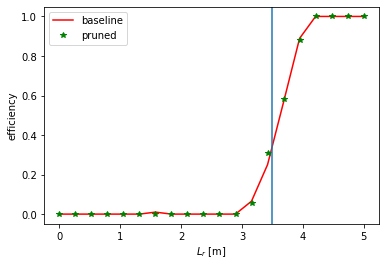

In [ ]:
numer_p,_ = np.histogram(Y_test[predizioni_pruned.reshape(2000,)>soglia], bins=20, range=(0.,5.))
denum_p,_= np.histogram(Y_test, bins=20, range=(0.,5.))

eff_p = numer_p/denum_p

_ = plt.plot(lrvalues,eff, 'r-', label='baseline')
_ = plt.plot(lrvalues,eff_p, 'g*', label='pruned')
_ = plt.axvline(x=soglia)
_ = plt.xlabel("$L_r$ [m]")
_ = plt.ylabel("efficiency")
_ = plt.legend()



In [ ]:
# quantizzazione: usiamo tensorflow quantizer per quantizzare il modello a 8 bit e sfruttare le dpu delle schede FPGA Alveo
import tensorflow_model_optimization as tfmot

# sfruttiamo il modulo tfmot.quantization di tensorflow model optimization

# nel quantizzare i modelli (pesi e funzione di attivazione) è importante utilizzare la tecnica del quantization aware training 
# riaddestrando (anche solo per poche epoche) il modello quantizzato. La semplice quantizzazione di un modello pre-addestrato (post training quantization) di norma 
# porta ad uno scadimento importante delle prestazioni del modello finale


# quantizziamo il modello pruned usando la quantizzazione di tf a 8 bit: compressione x4, latenza CPU in inferenza ~x1.5-4
q_aware_model = tfmot.quantization.keras.quantize_model(pruned_model)

# quantized aware training richiede la ricompilazione del modello (stessi parametri del baseline model)
LR_ST=1e-3
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
q_aware_model.compile(optimizer=OPTIMIZER,
              loss='huber_loss',
              metrics=['mae'])

q_aware_model.summary()
# anche in questo caso tensorflow implementa un wrapper all'interno del modello che aiuta nelle operazioni di trainign del modello 
# quantizzato

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 333, 1)]      0         
                                                                 
 quantize_layer (QuantizeLay  (None, 20, 333, 1)       3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 20, 333, 32)      387       
 erV2)                                                           
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 20, 333, 32)      9315      
 pperV2)                                                         
                                                                 
 quant_conv2d_2 (QuantizeWra  (None, 20, 333, 32)      9249      
 pperV2)                                                     

In [ ]:
# trainign schedules
def lr_decay(epoch):
  if epoch < 5:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (5 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)


model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'q_best',
        monitor='val_mae',
        save_weights_only=False, 
        save_best_only=True,
        save_freq='epoch')

In [ ]:
# let's start to test with fine tuning for 1 epoch
history = q_aware_model.fit(X_train, Y_train, epochs=1, validation_split=0.2, verbose=1, callbacks=[model_checkpoint])

200/200 [==============================] - ETA: 0s - loss: 0.1390 - mae: 0.4166

INFO:tensorflow:Assets written to: q_best/assets


INFO:tensorflow:Assets written to: q_best/assets


200/200 [==============================] - 21s 96ms/step - loss: 0.1390 - mae: 0.4166 - val_loss: 0.0758 - val_mae: 0.3049


In [ ]:
model.load_weights('q_best')
model.save('q_aware_model_10.h5')

In [ ]:
# Prestazioni dei modelli: baseline, pruned e pruned+quantized

q_aware_model = keras.models.load_model('q_aware_model_10.h5')

#pruned_model.compile(optimizer=OPTIMIZER, loss='huber_loss',metrics=['mae'])

print('Baseline model:')
basescore = baseline_model.evaluate(X_test, Y_test, verbose=2)
print()
print('Pruned model:')
score_p = pruned_model.evaluate(X_test, Y_test, verbose=2)
print()
print('Pruned+Quantized model:')
score_q = q_aware_model.evaluate(X_test, Y_test, verbose=2)

Baseline model:
63/63 - 1s - loss: 0.0634 - mae: 0.2726 - 1s/epoch - 19ms/step

Pruned model:
63/63 - 1s - loss: 0.0634 - mae: 0.2726 - 983ms/epoch - 16ms/step

Pruned+Quantized model:
63/63 - 1s - loss: 0.0598 - mae: 0.2585 - 1s/epoch - 23ms/step


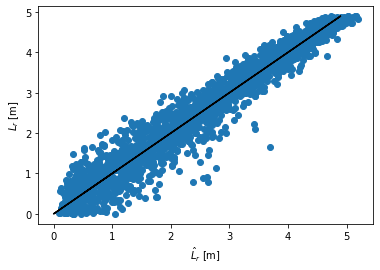

In [ ]:
predizioni_q = q_aware_model.predict(X_test.reshape((X_test.shape[0],20,333,1)))
plt.scatter(predizioni_q,Y_test)
plt.xlabel("$\hat{L}_r$ [m]")
plt.ylabel("$L_r$ [m]")
plt.plot(Y_test, Y_test ,'k-')

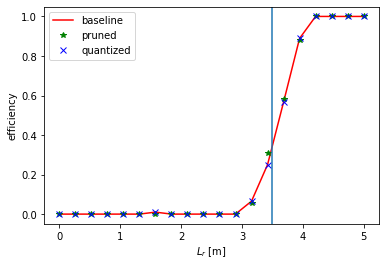

In [ ]:
numer_q,_ = np.histogram(Y_test[predizioni_q.reshape(2000,)>soglia], bins=20, range=(0.,5.))
denum_q,_ = np.histogram(Y_test, bins=20, range=(0.,5.))

eff_q = numer_q/denum_q

_ = plt.plot(lrvalues,eff, 'r-', label='baseline')
_ = plt.plot(lrvalues,eff_p, 'g*', label='pruned')
_ = plt.plot(lrvalues,eff_q, 'bx', label='quantized')
_ = plt.axvline(x=soglia)
_ = plt.xlabel("$L_r$ [m]")
_ = plt.ylabel("efficiency")
_ = plt.legend()


In [ ]:
# Conversione del modello pruned + quantizzato in TFlite in modo da eliminare il wrapper e verificare che effettivamente il modello 
# risulta correttamente compresso 

# pruned + compressed model
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# baseline model
baseline_model = keras.models.load_model('float_model_best_10.h5')
float_converter = tf.lite.TFLiteConverter.from_keras_model(baseline_model)
float_tflite_model = float_converter.convert()

# Measure sizes of models.
_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
  f.write(quantized_tflite_model)

with open(float_file, 'wb') as f:
  f.write(float_tflite_model)

print("Float model in Mb:", os.path.getsize(float_file) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(quant_file) / float(2**20))

INFO:tensorflow:Assets written to: /tmp/tmplxaf3wve/assets


INFO:tensorflow:Assets written to: /tmp/tmplxaf3wve/assets


INFO:tensorflow:Assets written to: /tmp/tmpcf3hgogf/assets


INFO:tensorflow:Assets written to: /tmp/tmpcf3hgogf/assets


Float model in Mb: 4.060802459716797
Quantized model in Mb: 1.0360107421875


## Quantizzazione con VitisAI

VitisAI richiede Docker e quindi non può essere eseguito su colab

Qui vi faccio vedere il codice necessario ad utilizzarlo e poi lo farò girare su un server ubuntu a Roma in cui è stato installato VitisAI v1.4

Purtroppo per un problema di kernel supportati da Xilinx per le Alveo U50 la scheda installata ha smesso di funzionare dopo l'ultimo update di ubuntu e quindi vi posso far vedere solo la compilazione ma non l'esecuzione sull'acceleratore...

istruzioni sull'installazione + un tutorial basato su TF/keras è disponibile sull'area github di VitisAI: [VitiAItuorial](https://github.com/Xilinx/Vitis-AI-Tutorials/blob/master/Design_Tutorials/08-tf2_flow/README.md) 

Esecuzione container VitisAI:


```
./docker_run.sh xilinx/vitis-ai-cpu:1.4.1.978
```

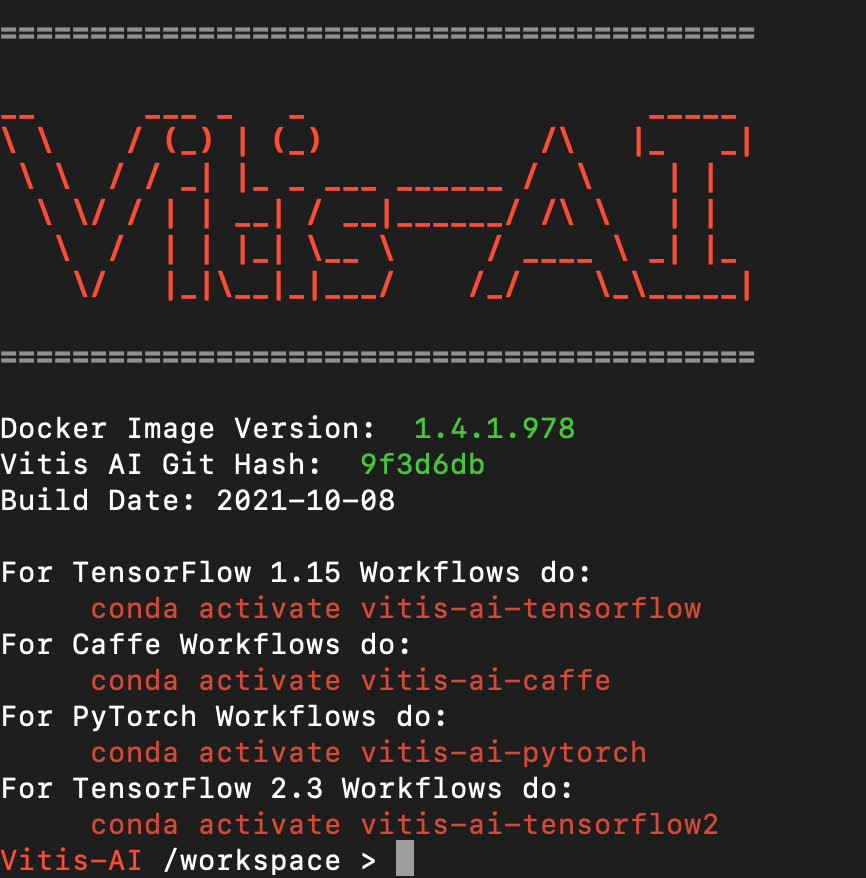

utilizare:


```
conda activate vitis-ai-tensorflow2
```

In [ ]:
# script python per la quantizzazione del modello prodotto con tensroflow 

import argparse
import os
import shutil
import sys

# Silence TensorFlow messages
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

import tensorflow as tf
from tensorflow import keras
from tensorflow_model_optimization.quantization.keras import vitis_quantize
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import numpy as np

# load data
input_file = np.load('MS_vertex_decays_10_v2.npz')
labels = input_file['labels']
data_noise = input_file['data_noise']

print("data_noise shape : ",data_noise.shape)
print("labels shape :     ",labels.shape)

decay_lenght = labels[:,0]

from sklearn.model_selection import train_test_split
train_to_test_ratio = 0.8 # training set 80%, test set 20%

X_train,X_test,Y_train,Y_test = train_test_split(data_noise, decay_lenght, train_size=train_to_test_ratio, shuffle=True, random_state=1234)

# reshaping delle immagini da (10000,20,333) a (10000,20,333,1) come richiesto da layer convoluzionali in keras
X_train = X_train.reshape((X_train.shape[0], 20, 333,1))
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

# conversione dei valori degli array a float32 come richiesto da keras
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')
X_test = X_test.astype('float32')
Y_test  = Y_test.astype('float32')

# load the floating point trained model
float_model = keras.models.load_model('float_model_best_10.h5')

# create tf dataset (needed for Vitis Quantizer)
quant_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
quant_dataset = quant_dataset.shuffle(X_train.shape[0]).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.shuffle(X_test.shape[0]).batch(64)

# run quantization
quantizer = vitis_quantize.VitisQuantizer(float_model)

# post training quantization (PTQ)
#quantized_model = quantizer.quantize_model(calib_dataset=quant_dataset)

# quantization aware training (QAT)
quantized_model = quantizer.get_qat_model()

quantized_model.compile(optimizer=Adam(),
                                loss='mse',
                                metrics=['mae'])

history = quantized_model.fit(quant_dataset, epochs=10, batch_size=64,
                validation_data=(test_dataset), shuffle=True, verbose=1)

# saved quantized model
quantized_model.save('quant_model_best_10.h5')


'''
Evaluate quantized model
'''
print ('Evaluating quantized model..')
scores = quantized_model.evaluate(test_dataset, verbose=2)


In [ ]:
#shell script per la compilazione su target U50 del modello quantizzato

# da eseguire (in ambiente VitisAI) come: source compile.sh 


ARCH=/opt/vitis_ai/compiler/arch/DPUCAHX8H/U50/arch.json
TARGET=u50
echo "-----------------------------------------"
echo "COMPILING MODEL FOR ALVEO U50.."
echo "-----------------------------------------"

compile() {
      vai_c_tensorflow2 \
            --model           quant_model_best_10.h5 \
            --arch            $ARCH \
            --output_dir      build/compiled_$TARGET \
            --net_name        customcnn
}


compile 2>&1 | tee build/compile_$TARGET.log

echo "-----------------------------------------"
echo "MODEL COMPILED"
echo "-----------------------------------------"


